In [3]:
def get_good_slices(arr, s_indx=0):
    slices = []
    for i in range(s_indx, len(arr)):
        if arr[i].max() > 0:
            slices.append(i)
    return slices

In [4]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits17/w_text/ct_liver_segmentation_run1/'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1.5)
tune_lora_scale(pipe.text_encoder, 1)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)


/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 9409.54it/s]


(685, 512, 512)
276


100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.44it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


decoding seg img


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


decoding seg img


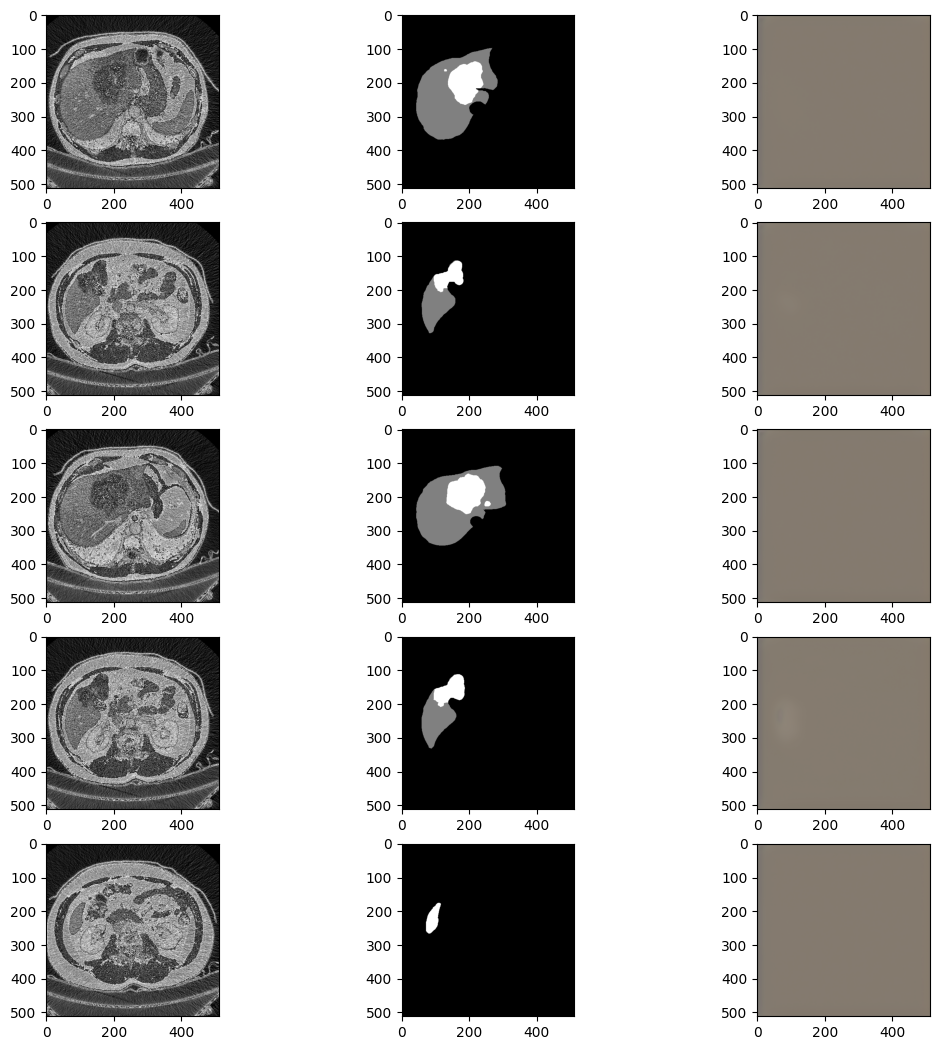

In [15]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
import os

n = 100
PATH = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/'
seg_path = os.path.join(PATH,f'segmentation-{n}.nii')
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
seg_img = sitk.ReadImage(seg_path, sitk.sitkUInt8)

img = sitk.GetArrayFromImage(img)
seg_img = sitk.GetArrayFromImage(seg_img)
print(img.shape)

slices = get_good_slices(seg_img)
print(len(slices))

n_examples = 5
indices = random.sample(slices, n_examples)
fig, ax = plt.subplots(n_examples, 3, figsize=(13,13))
for i, indx in enumerate(indices):
    ax[i, 0].imshow(img[indx], cmap='gray')
    ax[i, 1].imshow(seg_img[indx], cmap='gray')
    in_img = Image.fromarray(img[indx]).convert('RGB')
    output = pipe('segmentation map of liver', in_img, strength=0.1, guidance_scale=12, modified_unet=True, segmentation=True).images[0]
    ax[i, 2].imshow(output, cmap='gray')

plt.show()


In [1]:
def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

import xml.etree.ElementTree as ET
import os

def get_annotations(img_paths, annotations_root):
    voc_classes = {'background' : 'background',
                    'aeroplane' : 'aeroplane',
                    'bicycle' : 'bicycle',
                    'bird' : 'bird',
                    'boat' : 'boat',
                    'bottle' : 'bottle',
                    'bus' : 'bus',
                    'car' : 'car',
                    'cat' : 'cat',
                    'chair' : 'chair',
                    'cow' : 'cow',
                    'diningtable' : 'dining table',
                    'dog' : 'dog',
                    'horse' : 'horse',
                    'motorbike' : 'motorbike',
                    'person' : 'person',
                    'pottedplant' : 'potted plant',
                    'sheep' : 'sheep',
                    'sofa' : 'sofa',
                    'train' : 'train',
                    'tvmonitor' : 'tv monitor'}

    images_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]
    xmls_paths = [os.path.join(annotations_root, img_name +'.xml') for img_name in images_names]
    
    annotations = []
    for path in xmls_paths:
        tree = ET.parse(path)
        root = tree.getroot()
        annontation = root.find('object/name')

        annotations += [voc_classes[annontation.text]]

    return annotations

# Sample random pics and get their seg
import os
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,neg_prompt=None, save_path=None):
    N_PICS = 9
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, N_PICS)
    annotations_root = '/disk4/Lev/Projects/diffusion_finetuning/data/Annotations/'
    annotations = get_annotations(filenames, annotations_root)

    fig , ax = plt.subplots(N_PICS, 2,figsize=(15, 40))
    for i, item in enumerate(zip(filenames, annotations)):
        f, annotation = item
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        
        full_prompt = prompt + ' ' + annotation
        image = pipe(prompt=full_prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(full_prompt + ' ' + f)

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()

